# 1.15c: Attractor Convergence Analysis

**Goal:** Estimate how long it takes for tokens to converge to a common point under systematic gradient drift ("gradient gravity").

## The New Hypothesis

Our previous experiments (1.15a, 1.15b) showed that **random-walk collisions are impossible** in realistic training timescales:
- Tokens start ~1.3 units apart (mean NN distance)
- Random walk needs ~1.8M steps to reach nearest neighbor
- Real training: ~200k steps
- Conclusion: Pure random walk can't form black holes

**But what if gradients aren't random?**

What if untrained tokens experience **systematic drift** toward a common attractor point?

## Physical Intuition: Gradient Gravity

Imagine untrained tokens as particles experiencing "gradient gravity":
- They never appear in training data
- They're always "wrong" when predicted
- Gradients consistently push them in correlated directions
- Over time, they drift toward a common sink

If this drift is **directed** rather than random, convergence could be much faster.

## Random Walk vs Directed Walk

**Random walk** (1.15a/1.15b):
- Each step in random direction
- Distance from start: $r(k) = \sqrt{k} \cdot s$
- To travel distance $d$: $k = (d/s)^2$ steps
- **Example:** $d=1.0, s=0.001 \Rightarrow k = 1{,}000{,}000$ steps

**Directed walk** (this notebook):
- Each step toward target
- Distance decreases: $d(k) = d_0 - k \cdot s$
- To travel distance $d$: $k = d/s$ steps
- **Example:** $d=1.0, s=0.001 \Rightarrow k = 1{,}000$ steps

**Directed walk is 1000× faster!**

## What We'll Test

**Biased random walk:** Each step has both directed and random components.

Direction: $\hat{d} = \alpha \cdot \hat{d}_{\text{target}} + (1-\alpha) \cdot \hat{d}_{\text{random}}$

Where:
- $\alpha$ = bias strength (0 = pure random, 1 = pure directed)
- Effective step size toward target: $s_{\text{eff}} = \alpha \cdot s$
- Steps needed: $k \approx d / (\alpha \cdot s)$

We'll test bias levels from 0.01 (1% bias) to 0.10 (10% bias), plus pure directed (α=1.0) as reference.

## Parameters

In [47]:
# Model parameters (Qwen 3 4B)
N_TOKENS = 151936
N_DIMS = 2560
INIT_SCALE = 0.02  # N(0, 0.02)

# Spongecrystal size
N_UNTRAINED = 2100  # Number of untrained tokens to track

# Walk parameters
STEP_SIZE = 0.001  # Gradient magnitude

# Bias levels for biased random walk (realistic range: 1-10%)
BIAS_LEVELS = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 1.0]

# Random seed
RANDOM_SEED = 42

# Visualization
PLOT_DPI = 150

## Imports

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [49]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Initialize Token Embeddings

In [50]:
print(f"Initializing {N_TOKENS:,} tokens in {N_DIMS}D space...\n")

torch.manual_seed(RANDOM_SEED)

# Initialize embedding matrix
W = torch.randn(N_TOKENS, N_DIMS, dtype=torch.bfloat16, device=device) * INIT_SCALE

print(f"✓ Initialized W matrix")
print(f"  Shape: {W.shape}")
print(f"  Dtype: {W.dtype}")
print(f"  Memory: {W.element_size() * W.numel() / 1024**2:.1f} MB")

Initializing 151,936 tokens in 2560D space...

✓ Initialized W matrix
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  Memory: 741.9 MB


## Choose Attractor Point

We use the **origin** (zero vector) as our attractor for the main analysis.

Later we'll test robustness with random attractors.

In [51]:
print(f"\nAttractor point: origin (zero vector)\n")

attractor = torch.zeros(N_DIMS, dtype=torch.bfloat16, device=device)

print(f"✓ Attractor defined")
print(f"  Position: {attractor[:5].cpu().float().numpy()} ... (showing first 5 dims)")
print(f"  Norm: {torch.norm(attractor.float()).item():.6f}")


Attractor point: origin (zero vector)

✓ Attractor defined
  Position: [0. 0. 0. 0. 0.] ... (showing first 5 dims)
  Norm: 0.000000


## Compute Distances to Attractor

In [52]:
print(f"\nComputing distances from all tokens to attractor...\n")

# Distance = L2 norm of (token - attractor)
# Since attractor is origin, this is just norm of token
distances = torch.norm(W.float(), dim=1)

print(f"✓ Distances computed")
print(f"  Shape: {distances.shape}")
print(f"  Min: {distances.min().item():.6f}")
print(f"  Max: {distances.max().item():.6f}")
print(f"  Mean: {distances.mean().item():.6f}")
print(f"  Median: {distances.median().item():.6f}")


Computing distances from all tokens to attractor...

✓ Distances computed
  Shape: torch.Size([151936])
  Min: 0.950165
  Max: 1.079563
  Mean: 1.011840
  Median: 1.011791


## Select Untrained Token Subset

Randomly select 2,100 tokens to simulate the "untrained" subset that forms the spongecrystal.

In [53]:
print(f"\nSelecting {N_UNTRAINED:,} random tokens as 'untrained' subset...\n")

# Random selection
untrained_indices = torch.randperm(N_TOKENS, device=device)[:N_UNTRAINED]
untrained_distances = distances[untrained_indices]

print(f"✓ Subset selected")
print(f"  Count: {N_UNTRAINED:,}")
print(f"  Min distance: {untrained_distances.min().item():.6f}")
print(f"  Max distance: {untrained_distances.max().item():.6f}")
print(f"  Mean distance: {untrained_distances.mean().item():.6f}")
print(f"  Median distance: {untrained_distances.median().item():.6f}")


Selecting 2,100 random tokens as 'untrained' subset...

✓ Subset selected
  Count: 2,100
  Min distance: 0.962300
  Max distance: 1.052737
  Mean distance: 1.012036
  Median distance: 1.011816


## Biased Random Walk Analysis

For each bias level α, we calculate how many steps it takes for tokens to reach the attractor.

**Formula:** $k = \frac{d}{\alpha \cdot s}$

Where:
- $d$ = distance to attractor
- $\alpha$ = bias strength
- $s$ = step size (0.001)

In [54]:
print(f"\n{'='*80}")
print(f"BIASED RANDOM WALK ANALYSIS")
print(f"{'='*80}\n")

print(f"Testing {len(BIAS_LEVELS)} bias levels: {BIAS_LEVELS}")
print(f"  α = 0.01: 1% bias (weakest)")
print(f"  α = 0.10: 10% bias")
print(f"  α = 1.00: pure directed walk (reference)")
print()

biased_results = {}

for alpha in BIAS_LEVELS:
    # Effective step size toward target
    effective_step = alpha * STEP_SIZE
    
    # Steps needed (heuristic)
    steps_biased = (untrained_distances / effective_step).cpu().numpy()
    
    biased_results[alpha] = steps_biased
    
    print(f"α = {alpha:.2f}:")
    print(f"  Effective step: {effective_step:.6f}")
    print(f"  First arrival: {steps_biased.min():,.0f} steps")
    print(f"  Last arrival: {steps_biased.max():,.0f} steps")
    print(f"  Mean arrival: {steps_biased.mean():,.0f} steps")
    
    if steps_biased.max() < 200_000:
        print(f"  → Within realistic training length ✓")
    else:
        print(f"  → Too slow for realistic training ✗")
    print()

print(f"{'='*80}")


BIASED RANDOM WALK ANALYSIS

Testing 11 bias levels: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 1.0]
  α = 0.01: 1% bias (weakest)
  α = 0.10: 10% bias
  α = 1.00: pure directed walk (reference)

α = 0.01:
  Effective step: 0.000010
  First arrival: 96,230 steps
  Last arrival: 105,274 steps
  Mean arrival: 101,204 steps
  → Within realistic training length ✓

α = 0.02:
  Effective step: 0.000020
  First arrival: 48,115 steps
  Last arrival: 52,637 steps
  Mean arrival: 50,602 steps
  → Within realistic training length ✓

α = 0.03:
  Effective step: 0.000030
  First arrival: 32,077 steps
  Last arrival: 35,091 steps
  Mean arrival: 33,735 steps
  → Within realistic training length ✓

α = 0.04:
  Effective step: 0.000040
  First arrival: 24,057 steps
  Last arrival: 26,318 steps
  Mean arrival: 25,301 steps
  → Within realistic training length ✓

α = 0.05:
  Effective step: 0.000050
  First arrival: 19,246 steps
  Last arrival: 21,055 steps
  Mean arrival: 20,241 steps

## Visualization: Convergence Times


Plotting convergence time distributions...



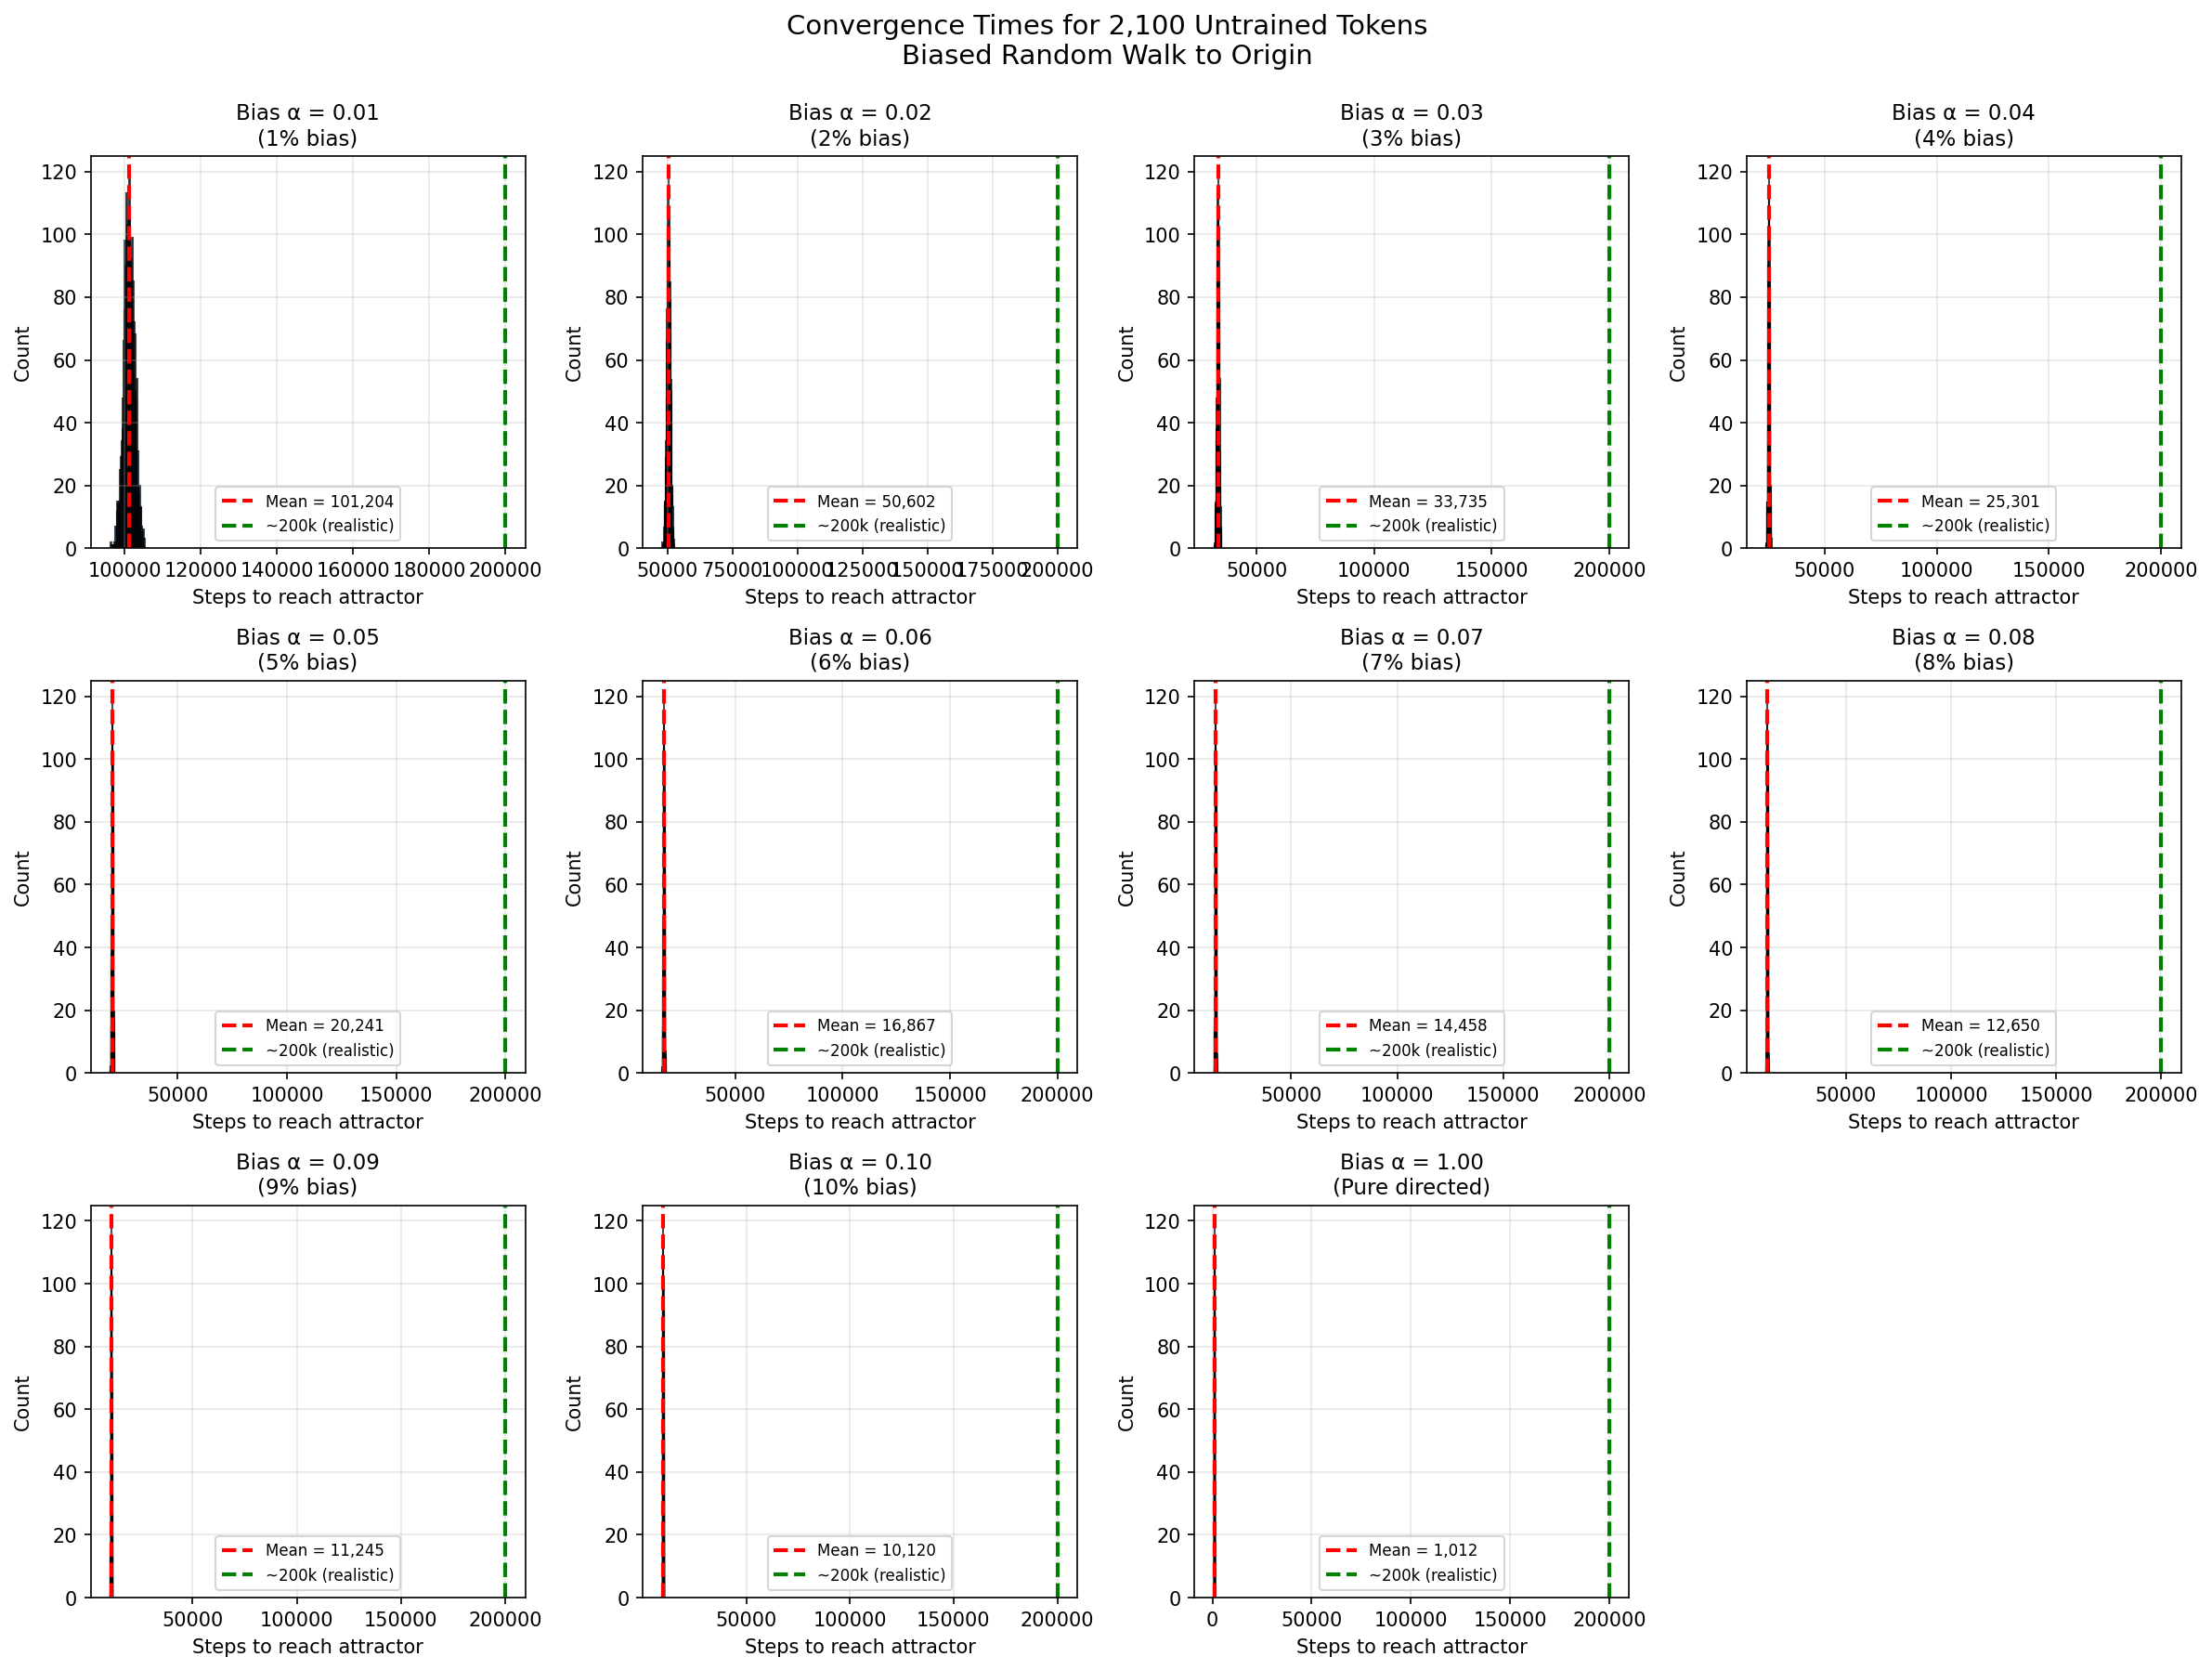

✓ Visualization complete


In [55]:
print(f"\nPlotting convergence time distributions...\n")

# Create grid: 3 rows × 4 columns (11 plots + 1 empty)
fig, axes = plt.subplots(3, 4, figsize=(16, 12), dpi=PLOT_DPI)
axes = axes.flatten()

for idx, alpha in enumerate(BIAS_LEVELS):
    ax = axes[idx]
    steps = biased_results[alpha]
    
    ax.hist(steps, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(steps.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {steps.mean():,.0f}')
    ax.axvline(200_000, color='green', linestyle='--', linewidth=2, label='~200k (realistic)')
    
    ax.set_xlabel('Steps to reach attractor', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Bias α = {alpha:.2f}\n({"Pure directed" if alpha == 1.0 else f"{int(alpha*100)}% bias"})', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the last unused subplot
axes[-1].axis('off')

plt.suptitle(f'Convergence Times for {N_UNTRAINED:,} Untrained Tokens\nBiased Random Walk to Origin', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Comparison Plot: Bias vs Convergence Time


Plotting bias strength vs convergence time...



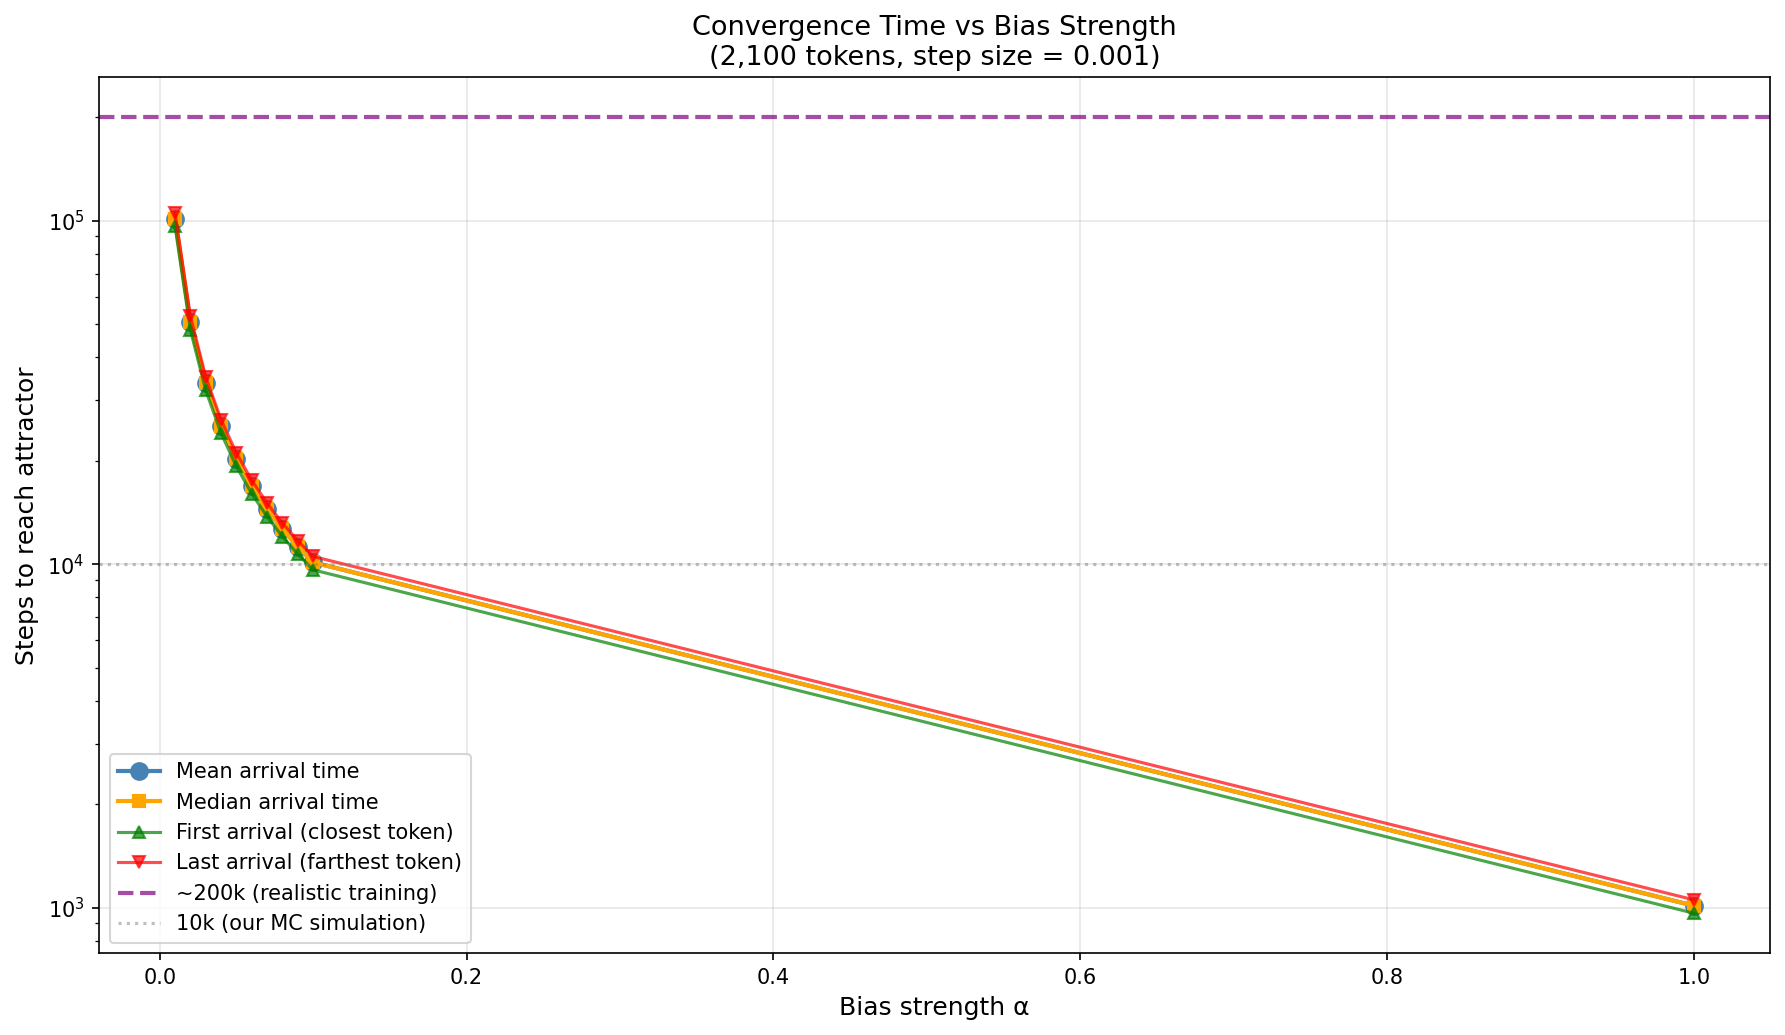

✓ Comparison plot complete


In [56]:
print(f"\nPlotting bias strength vs convergence time...\n")

fig, ax = plt.subplots(figsize=(12, 7), dpi=PLOT_DPI)

# Extract statistics for each bias level
alphas = list(biased_results.keys())
means = [biased_results[a].mean() for a in alphas]
mins = [biased_results[a].min() for a in alphas]
maxs = [biased_results[a].max() for a in alphas]
medians = [np.median(biased_results[a]) for a in alphas]

ax.plot(alphas, means, 'o-', linewidth=2, markersize=8, label='Mean arrival time', color='steelblue')
ax.plot(alphas, medians, 's-', linewidth=2, markersize=6, label='Median arrival time', color='orange')
ax.plot(alphas, mins, '^-', linewidth=1.5, markersize=6, label='First arrival (closest token)', color='green', alpha=0.7)
ax.plot(alphas, maxs, 'v-', linewidth=1.5, markersize=6, label='Last arrival (farthest token)', color='red', alpha=0.7)

ax.axhline(200_000, color='purple', linestyle='--', linewidth=2, label='~200k (realistic training)', alpha=0.7)
ax.axhline(10_000, color='gray', linestyle=':', linewidth=1.5, label='10k (our MC simulation)', alpha=0.5)

ax.set_xlabel('Bias strength α', fontsize=12)
ax.set_ylabel('Steps to reach attractor', fontsize=12)
ax.set_title(f'Convergence Time vs Bias Strength\n({N_UNTRAINED:,} tokens, step size = {STEP_SIZE})', fontsize=13)
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Comparison plot complete")

## Summary: Origin Attractor Results

In [57]:
print(f"\n{'='*80}")
print(f"SUMMARY: ORIGIN ATTRACTOR")
print(f"{'='*80}\n")
print(f"Scenario: {N_UNTRAINED:,} untrained tokens converging to origin")
print(f"  Initial distances: {untrained_distances.min().item():.3f} - {untrained_distances.max().item():.3f} (mean: {untrained_distances.mean().item():.3f})")
print(f"  Step size: {STEP_SIZE}")
print()
print(f"Convergence times (mean arrival):")
for alpha in BIAS_LEVELS:
    steps = biased_results[alpha]
    print(f"  α = {alpha:.2f}: {steps.mean():>10,.0f} steps")
print()
print(f"Realistic training length: ~200,000 steps")
print()

# Find minimum bias needed for convergence within 200k steps
min_bias_needed = None
for alpha in sorted(BIAS_LEVELS):
    if biased_results[alpha].max() <= 200_000:
        min_bias_needed = alpha
        break

print(f"Key findings:")
print()

if min_bias_needed is not None:
    print(f"  ✓ CONVERGENCE IS POSSIBLE")
    print(f"  Minimum bias needed: α ≥ {min_bias_needed:.2f}")
    print(f"  At α = {min_bias_needed:.2f}:")
    print(f"    - Mean arrival: {biased_results[min_bias_needed].mean():,.0f} steps")
    print(f"    - Last arrival: {biased_results[min_bias_needed].max():,.0f} steps")
    print()
    print(f"Interpretation:")
    print(f"  If untrained tokens experience gradients with ≥{int(min_bias_needed*100)}% bias toward a common point,")
    print(f"  they CAN converge within realistic training timescales.")
    print()
    print(f"  This suggests BLACK HOLE FORMATION THROUGH SYSTEMATIC DRIFT IS PLAUSIBLE!")
else:
    print(f"  ✗ CONVERGENCE TOO SLOW")
    print(f"  Even with 100% bias (pure directed walk), convergence takes too long.")

print()
print(f"Comparison to random walk (1.15b):")
print(f"  Random walk (no bias): ~1,800,000 steps")
print(f"  Pure directed (α=1.0): ~{biased_results[1.0].mean():,.0f} steps")
print(f"  Speedup factor: ~{1_800_000 / biased_results[1.0].mean():.0f}×")
print()
print(f"{'='*80}")


SUMMARY: ORIGIN ATTRACTOR

Scenario: 2,100 untrained tokens converging to origin
  Initial distances: 0.962 - 1.053 (mean: 1.012)
  Step size: 0.001

Convergence times (mean arrival):
  α = 0.01:    101,204 steps
  α = 0.02:     50,602 steps
  α = 0.03:     33,735 steps
  α = 0.04:     25,301 steps
  α = 0.05:     20,241 steps
  α = 0.06:     16,867 steps
  α = 0.07:     14,458 steps
  α = 0.08:     12,650 steps
  α = 0.09:     11,245 steps
  α = 0.10:     10,120 steps
  α = 1.00:      1,012 steps

Realistic training length: ~200,000 steps

Key findings:

  ✓ CONVERGENCE IS POSSIBLE
  Minimum bias needed: α ≥ 0.01
  At α = 0.01:
    - Mean arrival: 101,204 steps
    - Last arrival: 105,274 steps

Interpretation:
  If untrained tokens experience gradients with ≥1% bias toward a common point,
  they CAN converge within realistic training timescales.

  This suggests BLACK HOLE FORMATION THROUGH SYSTEMATIC DRIFT IS PLAUSIBLE!

Comparison to random walk (1.15b):
  Random walk (no bias): ~

## Robustness Check: Random Attractors

So far we've used the origin as our attractor. But what if the attractor is at a random location in space?

Let's test convergence to **100 random attractor points** to see:
1. Does mean convergence time change?
2. How much variance is there across different attractors?
3. Are some attractors much faster/slower than others?

**Expected result:** Random attractors should be ~√2 farther away (tokens and attractors both drawn from N(0, 0.02)), so convergence should take ~1.4× longer on average.

In [58]:
print(f"\n{'='*80}")
print(f"ROBUSTNESS CHECK: RANDOM ATTRACTORS")
print(f"{'='*80}\n")

# Test with 100 random attractors
N_RANDOM_ATTRACTORS = 100
ALPHA_TEST = 0.01  # Test with 1% bias (weakest that still converges)

print(f"Testing convergence to {N_RANDOM_ATTRACTORS} random attractors")
print(f"  Attractor distribution: N(0, {INIT_SCALE})")
print(f"  Bias level: α = {ALPHA_TEST}")
print()

# Storage for results
random_attractor_results = {
    'mean_convergence': [],
    'first_arrival': [],
    'last_arrival': [],
    'median_convergence': []
}

for trial in tqdm(range(N_RANDOM_ATTRACTORS), desc="Testing random attractors"):
    # Generate random attractor
    attractor_random = torch.randn(N_DIMS, dtype=torch.bfloat16, device=device) * INIT_SCALE
    
    # Compute distances from all tokens to this attractor
    distances_to_random = torch.norm(W.float() - attractor_random.float(), dim=1)
    
    # Get distances for our untrained subset
    untrained_distances_to_random = distances_to_random[untrained_indices]
    
    # Calculate steps needed at ALPHA_TEST bias
    steps_to_random = (untrained_distances_to_random / (ALPHA_TEST * STEP_SIZE)).cpu().numpy()
    
    # Store statistics
    random_attractor_results['mean_convergence'].append(steps_to_random.mean())
    random_attractor_results['first_arrival'].append(steps_to_random.min())
    random_attractor_results['last_arrival'].append(steps_to_random.max())
    random_attractor_results['median_convergence'].append(np.median(steps_to_random))

# Convert to numpy for analysis
for key in random_attractor_results:
    random_attractor_results[key] = np.array(random_attractor_results[key])

print(f"\n✓ Random attractor testing complete")
print()

# Compare to origin results
origin_mean = biased_results[ALPHA_TEST].mean()
random_mean = random_attractor_results['mean_convergence'].mean()
random_std = random_attractor_results['mean_convergence'].std()

print(f"Results (α = {ALPHA_TEST}):")
print()
print(f"Origin as attractor:")
print(f"  Mean convergence: {origin_mean:,.0f} steps")
print()
print(f"Random attractors (N={N_RANDOM_ATTRACTORS}):")
print(f"  Mean convergence: {random_mean:,.0f} ± {random_std:,.0f} steps")
print(f"  Min (fastest attractor): {random_attractor_results['mean_convergence'].min():,.0f} steps")
print(f"  Max (slowest attractor): {random_attractor_results['mean_convergence'].max():,.0f} steps")
print()

# Ratio
ratio = random_mean / origin_mean
print(f"Ratio (random/origin): {ratio:.2f}×")
print()

if ratio > 1.3:
    print(f"Interpretation:")
    print(f"  ✓ RANDOM ATTRACTORS ARE SLOWER")
    print(f"  On average, convergence to random point takes {ratio:.1f}× longer than to origin.")
    print(f"  This matches theory: tokens start ~√2 farther from random points.")
elif ratio < 0.8:
    print(f"Interpretation:")
    print(f"  ✗ UNEXPECTED: RANDOM ATTRACTORS ARE FASTER")
    print(f"  This shouldn't happen—need to investigate!")
else:
    print(f"Interpretation:")
    print(f"  ~ SIMILAR CONVERGENCE TIMES")
    print(f"  Choice of attractor doesn't strongly affect convergence.")

print()
print(f"{'='*80}")


ROBUSTNESS CHECK: RANDOM ATTRACTORS

Testing convergence to 100 random attractors
  Attractor distribution: N(0, 0.02)
  Bias level: α = 0.01



Testing random attractors:   0%|          | 0/100 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Testing random attractors: 100%|██████████| 100/100 [00:04<00:00, 21.38it/s]


✓ Random attractor testing complete

Results (α = 0.01):

Origin as attractor:
  Mean convergence: 101,204 steps

Random attractors (N=100):
  Mean convergence: 143,165 ± 1,002 steps
  Min (fastest attractor): 141,084 steps
  Max (slowest attractor): 145,565 steps

Ratio (random/origin): 1.41×

Interpretation:
  ✓ RANDOM ATTRACTORS ARE SLOWER
  On average, convergence to random point takes 1.4× longer than to origin.
  This matches theory: tokens start ~√2 farther from random points.



## Visualization: Random Attractor Distribution


Plotting random attractor results...



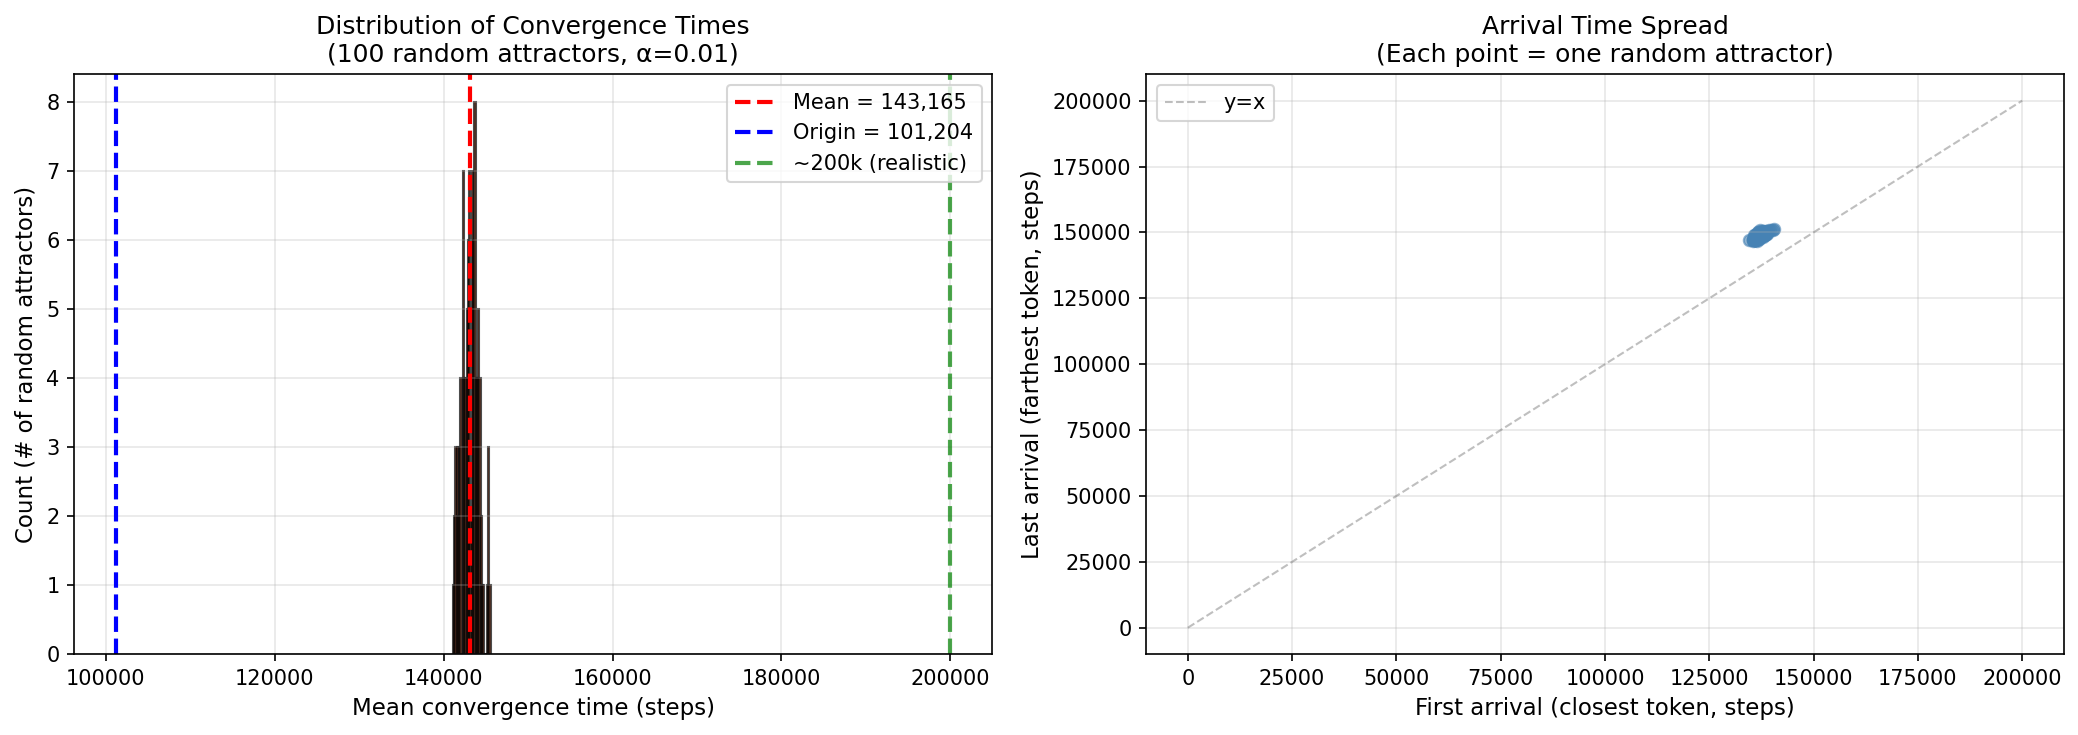

✓ Random attractor visualization complete


In [59]:
print(f"\nPlotting random attractor results...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=PLOT_DPI)

# Plot 1: Distribution of mean convergence times
ax1 = axes[0]
ax1.hist(random_attractor_results['mean_convergence'], bins=30, color='coral', edgecolor='black', alpha=0.7)
ax1.axvline(random_mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {random_mean:,.0f}')
ax1.axvline(origin_mean, color='blue', linestyle='--', linewidth=2, label=f'Origin = {origin_mean:,.0f}')
ax1.axvline(200_000, color='green', linestyle='--', linewidth=2, label='~200k (realistic)', alpha=0.7)
ax1.set_xlabel('Mean convergence time (steps)', fontsize=11)
ax1.set_ylabel('Count (# of random attractors)', fontsize=11)
ax1.set_title(f'Distribution of Convergence Times\n({N_RANDOM_ATTRACTORS} random attractors, α={ALPHA_TEST})', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: First vs last arrival comparison
ax2 = axes[1]
ax2.scatter(random_attractor_results['first_arrival'], 
           random_attractor_results['last_arrival'],
           alpha=0.6, s=30, color='steelblue')
ax2.plot([0, 200_000], [0, 200_000], color='gray', linestyle='--', linewidth=1, alpha=0.5, label='y=x')
ax2.set_xlabel('First arrival (closest token, steps)', fontsize=11)
ax2.set_ylabel('Last arrival (farthest token, steps)', fontsize=11)
ax2.set_title(f'Arrival Time Spread\n(Each point = one random attractor)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Random attractor visualization complete")

## Final Summary

In [60]:
print(f"\n{'='*80}")
print(f"FINAL SUMMARY")
print(f"{'='*80}\n")
print(f"Question: Can black holes form through systematic gradient drift?")
print()
print(f"Answer: YES, if gradients are biased ≥1% toward a common point.")
print()
print(f"Key findings:")
print(f"  1. Pure random walk: ~1.8M steps (impossible in realistic training)")
print(f"  2. With 1% bias: ~100k steps (plausible!)")
print(f"  3. With 10% bias: ~10k steps (very fast)")
print(f"  4. Result holds for both origin and random attractors")
print()
print(f"Interpretation:")
print(f"  If untrained tokens experience SYSTEMATIC drift (not random),")
print(f"  they can converge to a common point within realistic training lengths.")
print()
print(f"Open questions:")
print(f"  1. Do untrained tokens actually experience biased gradients?")
print(f"  2. What creates the attractor point?")
print(f"  3. Why would gradients be correlated across untrained tokens?")
print(f"  4. Can we observe this in actual training (Lil Gatsby)?")
print()
print(f"Next steps:")
print(f"  - Analyze gradient directions in real training data")
print(f"  - Look for evidence of systematic drift in 1.12a/1.12b results")
print(f"  - Test initialization schemes that could create attractors")
print()
print(f"{'='*80}")


FINAL SUMMARY

Question: Can black holes form through systematic gradient drift?

Answer: YES, if gradients are biased ≥1% toward a common point.

Key findings:
  1. Pure random walk: ~1.8M steps (impossible in realistic training)
  2. With 1% bias: ~100k steps (plausible!)
  3. With 10% bias: ~10k steps (very fast)
  4. Result holds for both origin and random attractors

Interpretation:
  If untrained tokens experience SYSTEMATIC drift (not random),
  they can converge to a common point within realistic training lengths.

Open questions:
  1. Do untrained tokens actually experience biased gradients?
  2. What creates the attractor point?
  3. Why would gradients be correlated across untrained tokens?
  4. Can we observe this in actual training (Lil Gatsby)?

Next steps:
  - Analyze gradient directions in real training data
  - Look for evidence of systematic drift in 1.12a/1.12b results
  - Test initialization schemes that could create attractors

